In [109]:
import pandas as pd
import numpy as np
import json
from pandas import DataFrame
from pandas.io.json import json_normalize
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer
import nltk
import string
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import stopwords
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as pyplot
%matplotlib inline

In [110]:
df = pd.read_excel("/home/surya/Nightingale_Chat_NEW.xlsx",sheet_name = "All", header=0)
print(df.rating.value_counts())
df = df.drop_duplicates()
print(len(df) , len(df.drop_duplicates()))
print(pd.concat([df.head(), df.tail()]))

medium    3114
high      3031
low       2985
Name: rating, dtype: int64
9130 9130
                                           patient_chat rating
0     female, 55 years, 75 kg and obese. hypertensiv...   high
1     I'm 22 and male and I have gotten terrible mig...   high
2     My wife is constantly suffering from high bloo...   high
3     I get head aches multiple time times a week I'...   high
4     I recently suffered a substantial loss of belo...   high
9125   Hello John, how are you doing today? What can...    low
9126   Hello John, how are you doing today? What can...    low
9127   Hello John, how are you doing today? What can...    low
9128   Hello John, how are you doing today? What can...    low
9129   Hello John, how are you doing today? What can...    low


In [111]:
not_include_words = ['not' ,'didn', 'no',"hasn't","mustn't", 'haven', 'against', "doesn't", 'isn',"needn't", "wasn't",'needn', "mightn't","won't",'nor',"no" , "not at all","weren't",'mightn','might not',"didn't","couldn't","shouldn't","not", "no no", "mightn't","won't", "hadn't", "didn't","not" , "haven't","wouldn't"]
not_words = set(not_include_words)
stop_words = set(stopwords.words('english'))
discard_words = not_words
stop_words = stop_words - discard_words
print(stop_words)

{'into', 'it', 'having', 'same', 'his', 'did', 'on', 'or', 'to', "you'll", 'y', 'doesn', 'its', 'between', 'from', 'which', 'about', 'few', 'down', 'while', 's', 'hasn', 'mustn', 'with', 'over', 'being', 'at', 'hadn', 'couldn', 'itself', 'very', 'here', 'off', 'because', 'own', 'was', 'my', 'i', 'all', 'than', 'more', 'are', 'and', 'too', 'how', "you're", 't', 'me', 'now', "isn't", 'have', 'them', 'other', 'wouldn', 'ours', 're', 'been', 'him', 'can', 'you', 'should', "you'd", 'd', 'through', 'were', 'only', 'of', 'most', 'some', 'each', 'shan', "she's", 'just', 'where', 'during', 'after', 'won', 'if', 'is', 'there', 'our', 'herself', 'above', 'why', 'yourself', 'myself', 'weren', 'hers', 'but', 'she', 'll', 'once', 'ma', 'yours', 'do', 'will', 'when', 'any', 'ourselves', 'these', 'we', 'that', "it's", 'theirs', 'such', "shan't", 'am', 'as', 'does', 'ain', 'their', 'for', 'under', "you've", "that'll", 'by', 'who', 'both', 'wasn', 'whom', 'themselves', 'an', 'further', 'shouldn', 'himse

In [112]:
def load_file(filename):
    with open(filename) as f:
        d = json.load(f)
        df = DataFrame(d)
        f.close()
    return df

punc_ = set(string.punctuation)

In [113]:
def clean_document(doc) :
    
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    doc = doc.replace("Hello John,", "")
    tokens = doc.lower().split()
    
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha() or word.isalnum()]
#     stop_words = set(stopwords.words('english'))
    #remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in punc_]
    tokens = [re.sub('[^A-Za-z0-9]+', '', word)  for word in tokens]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

def preprocess_documents(docs):
    clean_docs = [clean_document(doc) for doc in docs]
    return clean_docs

In [114]:
docs = list(df.patient_chat)
clean_docs = preprocess_documents(docs)

In [115]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        pyplot.tight_layout()
        pyplot.legend()
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['acc'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_acc'], color='orange', label='test')
        pyplot.tight_layout()
        
    pyplot.show()

## Define Vocobulary

In [116]:
vocab = Counter()

# load doc and add to vocab
def add_doc_to_vocab(doc,vocab):
    vocab.update(doc)
    return vocab

# load all docs in a directory
def process_docs(clean_docs, vocab):
    for doc in clean_docs:
        vocab = add_doc_to_vocab(doc, vocab)
    return vocab

vocab = process_docs(clean_docs, vocab)

# keep tokens with a min occurrence
min_occurrence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurrence]
print(len(tokens))

2491


### Total Vocobulary : $len(tokens) = 2491

In [117]:
# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()
    
# save tokens to a vocabulary file
save_list(tokens, 'nightingale_vocab.txt')

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load doc, clean and return line of tokens
def doc_to_line(doc, vocab):
    # filter by vocab
    tokens = [w for w in doc if w in vocab]
    return ' '.join(tokens)

In [118]:
!ls -ltr /home/surya/nightingale_vocab.txt

-rw-r--r--. 1 root root 18453 Jun 13 14:51 /home/surya/nightingale_vocab.txt


In [119]:
# load the vocabulary
vocab_filename = 'nightingale_vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [122]:
# 'no' in vocab

In [123]:
clean_doc_voc = []
for doc in clean_docs:
    clean_doc_voc.append(doc_to_line(doc, vocab))
    
df["clean_doc_voc"] = clean_doc_voc

In [124]:
df.rating  = df.rating.map({'low':0, 'medium':1, 'high' : 2})

In [125]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["clean_doc_voc","rating" ]], test_size=0.2)

xtrain_docs , y_train_docs= train["clean_doc_voc"] , train["rating"]
xtest_docs , y_test_docs= test["clean_doc_voc"] , test["rating"]

In [126]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


# encode data
tokenizer = create_tokenizer(xtrain_docs)
Xtrain = tokenizer.texts_to_matrix(xtrain_docs, mode='freq' )
print(len(tokenizer.word_index))
Xtest = tokenizer.texts_to_matrix(xtest_docs, mode='freq')
print(len(tokenizer.word_index))

2450
2450


In [127]:
len(tokenizer.word_index)

2450

In [128]:
print((Xtrain.shape ,y_train_docs.shape))
print((xtest_docs.shape, y_test_docs.shape))

((7304, 2451), (7304,))
((1826,), (1826,))


In [130]:
n_words = Xtest.shape[1]
n_words

2451

In [131]:
"n_word : "+str(Xtrain.shape[1])

'n_word : 2451'

####  MLP - Multi Layer perceptron models

2451
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 50)                122600    
_________________________________________________________________
dense_88 (Dense)             (None, 3)                 153       
Total params: 122,753
Trainable params: 122,753
Non-trainable params: 0
_________________________________________________________________
2491
Training Accuracy :  0.970 , Testing Accuracy : 0.922


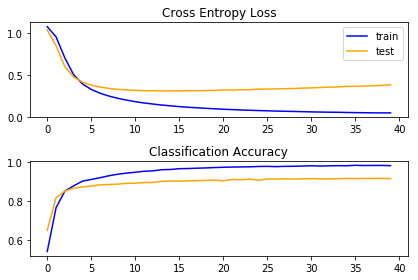

In [132]:
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model
print(n_words)
model = define_model(n_words)
print(len(set(vocab)))

# fit network for MLP based Model :  Input - 50 - 3 (softmax)
history = model.fit(Xtrain,
                    to_categorical(y_train_docs),
                    epochs=40,
                    validation_split=0.25,
                    verbose=0 )
histories = []
histories.append(history)
_,train_acc = model.evaluate(Xtrain, to_categorical(y_train_docs) ,verbose=0)
_, test_acc = model.evaluate(Xtest, to_categorical(y_test_docs), verbose=0)

print("Training Accuracy :  %.03f , Testing Accuracy : %.03f" %(train_acc ,test_acc) )

summarize_diagnostics(histories)
model.save("nightingale_freq_jun13.h5")

2451
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 50)                122600    
_________________________________________________________________
dense_96 (Dense)             (None, 3)                 153       
Total params: 122,753
Trainable params: 122,753
Non-trainable params: 0
_________________________________________________________________
2491
Training Accuracy :  0.890 , Testing Accuracy : 0.861


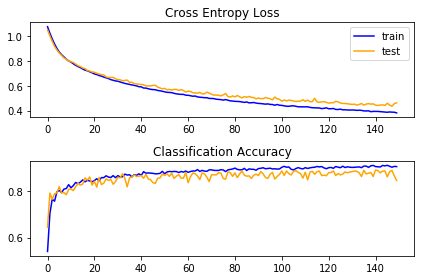

In [137]:
from keras.regularizers import l2 , l1_l2
from keras.constraints import unit_norm


# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu' ,  kernel_constraint=unit_norm()))
#     model.add(Dense(10,  activation='relu' ,  kernel_constraint=unit_norm()))
    model.add(Dense(3, activation='sigmoid'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model
print(n_words)
model = define_model(n_words)
print(len(set(vocab)))

# fit network for MLP based Model :  Input - 50 - 3 (softmax)
history = model.fit(Xtrain,
                    to_categorical(y_train_docs),
                    epochs=150,
                    validation_split=0.20,
                    verbose=0 )
histories = []
histories.append(history)
_,train_acc = model.evaluate(Xtrain, to_categorical(y_train_docs) ,verbose=0)
_, test_acc = model.evaluate(Xtest, to_categorical(y_test_docs), verbose=0)

print("Training Accuracy :  %.03f , Testing Accuracy : %.03f" %(train_acc ,test_acc) )

summarize_diagnostics(histories)

In [136]:
# model.save("nightingale_freq.h5")

In [138]:
import pickle

def save_tokenizer_file(object_, filename):
    # saving
    with open(filename, 'wb') as handle:
        pickle.dump(object_, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_tokenizer_file(filename):
    # loading
    with open(filename, 'rb') as handle:
        tokenizer = pickle.load(handle)
        return tokenizer
    return null
save_tokenizer_file(tokenizer,"tokenizer.pkl")

In [139]:
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode training data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [143]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 1
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = define_model(n_words)
        # fit network
        model.fit(Xtrain, ytrain, epochs=40, verbose=0)
        # evaluate
        _, acc = model.evaluate(Xtest, to_categorical(y_test_docs), verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

In [144]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Xtest = prepare_data(xtrain_docs, xtest_docs, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, to_categorical(y_train_docs), Xtest, to_categorical(y_test_docs))
    # summarize results
    # Comparing Word Scoring Methods
    print(results.describe())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 50)                122600    
_________________________________________________________________
dense_100 (Dense)            (None, 3)                 153       
Total params: 122,753
Trainable params: 122,753
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.9112814895947426
         binary
count  1.000000
mean   0.911281
std         NaN
min    0.911281
25%    0.911281
50%    0.911281
75%    0.911281
max    0.911281
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 50)                122600    
_________________________________________________________________
dense_102 (Dense)            (None, 3)                 153       
Total params: 122,753
Train

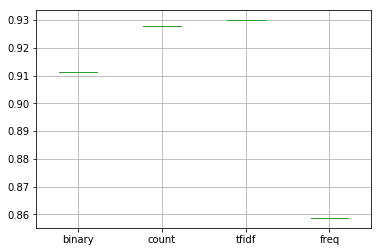

In [145]:
results.boxplot()
pyplot.show()

In [146]:
results_max = results.max()
results_max


binary    0.911281
count     0.927711
tfidf     0.929901
freq      0.858708
dtype: float64

###  Predict New Sentiment

In [152]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
    # clean
#     tokens = clean_doc(review)
    
    tokens = clean_document(text)
    print(tokens)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='tfidf')
    # predict sentiment
    yhat = model.predict(encoded, verbose=0)
    max_index = np.argmax(yhat[0])
    print(yhat[0])
    print(yhat[0][max_index])
    # retrieve predicted percentage and label
    percent_pos = yhat[0][max_index]
    if max_index == 0 : 
        return (percent_pos), '0'
    if max_index == 1 : 
        return (percent_pos), '1'
    if max_index == 2 : 
        return (percent_pos), '2'
    return "NA"

In [153]:
# test positive text
text = "my leg is getting hell lot of pain whihch is un imaginable blood due to pain!!"
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
percent, sentiment 

['leg', 'getting', 'hell', 'lot', 'pain', 'whihch', 'un', 'imaginable', 'blood', 'due', 'pain']
[2.1093590e-14 1.9759585e-03 9.9999988e-01]
0.9999999


(0.9999999, '2')

In [154]:
# test positive text
text = "my leg is paining alot and it is severe, couldn't bear any more"
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
percent, sentiment 

['leg', 'paining', 'alot', 'severe', 'couldnt', 'bear']
[6.4445152e-07 9.9569619e-01 1.7149778e-06]
0.9956962


(0.9956962, '1')

In [155]:
# test positive text
text = "no pain at all any more"
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
percent, sentiment 

['no', 'pain']
[7.0016968e-01 2.7104633e-04 4.1969312e-07]
0.7001697


(0.7001697, '0')

In [156]:
# test positive text
# text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

['no', 'pain']
[7.0016968e-01 2.7104633e-04 4.1969312e-07]
0.7001697
Review: [no pain at all any more]
Sentiment: 0 (70.017%)
['bad', 'movie']
[1.1977411e-04 2.2624556e-02 7.2459203e-05]
0.022624556
Review: [This is a bad movie.]
Sentiment: 1 (2.262%)


In [157]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [158]:
max_length = max([len(s.split()) for s in xtrain_docs])
print("Max length of line : ",max_length)

vocab_size = len(set(vocab))
print("Vocab Size : ", len(set(vocab)))

Max length of line :  105
Vocab Size :  2491


In [159]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 105, 300)          747300    
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 98, 32)            76832     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 49, 32)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 42, 32)            8224      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 21, 32)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 14, 32)            8224      
__________

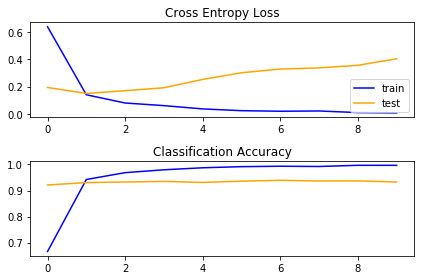

In [160]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding , Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GaussianNoise

encoded_docs = tokenizer.texts_to_sequences(xtrain_docs)

Xtrain  = encode_docs(tokenizer, max_length, xtrain_docs)
Xtest  = encode_docs(tokenizer, max_length, xtest_docs)


# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu' ,  ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GaussianNoise(0.1))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu' ,))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu' ))
    model.add(Dense(3, activation='sigmoid'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(vocab_size, max_length)
# fit network
history = model.fit(Xtrain, to_categorical(y_train_docs), 
          epochs=10, verbose=2,
          validation_data=(Xtest, to_categorical(y_test_docs)))
# save the model
# model.save('model_nightingale.h5')

histories = []
histories.append(history)
_,train_acc = model.evaluate(Xtrain, to_categorical(y_train_docs) ,verbose=0)
_, test_acc = model.evaluate(Xtest, to_categorical(y_test_docs), verbose=0)

print("Training Accuracy :  %.03f , Testing Accuracy : %.03f" %(train_acc ,test_acc) )

summarize_diagnostics(histories)
# model.save('model_nightingale_embedd_Jun13.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 105, 300)          747300    
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 105, 300)          0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 98, 32)            76832     
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 49, 32)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 42, 32)            8224      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 21, 32)            0         
__________

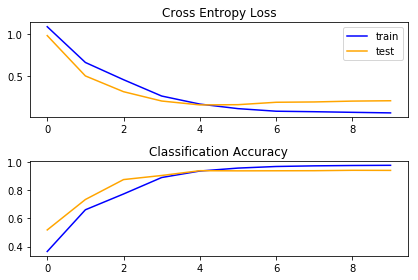

In [162]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding , Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GaussianNoise

encoded_docs = tokenizer.texts_to_sequences(xtrain_docs)

Xtrain  = encode_docs(tokenizer, max_length, xtrain_docs)
Xtest  = encode_docs(tokenizer, max_length, xtest_docs)


# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=max_length))
    model.add(GaussianNoise(0.1))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'  ))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'  ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'  ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(10, activation='relu' ))
    model.add(Dense(3, activation='sigmoid'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(vocab_size, max_length)
# fit network
history = model.fit(Xtrain, to_categorical(y_train_docs), 
          epochs=10, verbose=2,
          validation_data=(Xtest, to_categorical(y_test_docs)))
# save the model
# model.save('model_nightingale.h5')

histories = []
histories.append(history)
_,train_acc = model.evaluate(Xtrain, to_categorical(y_train_docs) ,verbose=0)
_, test_acc = model.evaluate(Xtest, to_categorical(y_test_docs), verbose=0)

print("Training Accuracy :  %.03f , Testing Accuracy : %.03f" %(train_acc ,test_acc) )

summarize_diagnostics(histories)
# model.save('model_nightingale_embedd_Jun13.h5')

In [164]:
# load the model
from keras.models import load_model
# save the model
model.save('model_nightingale_embedd_Jun13_ep50.h5')
# model = load_model('model_multi_nightingale.h5')

In [165]:
save_tokenizer_file(tokenizer, 'tokenizer.pkl')
tokenizer = load_tokenizer_file('tokenizer.pkl')
tokenizer

In [166]:
def save_file(data, filename):
    dump(data,filename)
    print('Saved: %s' % filename)

#########################

In [167]:
text = " Hello John,How can I help to you What causes headaches?please let me know Is it a throbbing headache?  How does bending forward affect your headache?  How would you describe the intensity of your headache?  Do you become frustrated or upset easily?  Have you recently used any drugs in any form?  Do you experience day time sleep?  Do you tend to drink alcohol heavily?  Are you feeling agitated and physically restless? "

In [168]:
tokens = clean_document(text)
print(tokens)
# filter by vocab
tokens = [w for w in tokens if w in vocab]
# # convert to line
line = ' '.join(tokens)
line

# # encode
# encoded = tokenizer.texts_to_matrix([line], mode='freq')
# # predict sentiment
# yhat = model.predict(encoded, verbose=0)

['help', 'causes', 'headachesplease', 'let', 'know', 'throbbing', 'headache', 'bending', 'forward', 'affect', 'headache', 'would', 'describe', 'intensity', 'headache', 'become', 'frustrated', 'upset', 'easily', 'recently', 'used', 'drugs', 'form', 'experience', 'day', 'time', 'sleep', 'tend', 'drink', 'alcohol', 'heavily', 'feeling', 'agitated', 'physically', 'restless']


'help causes headachesplease let know throbbing headache bending forward affect headache would describe intensity headache become frustrated upset easily recently used drugs form experience day time sleep tend drink alcohol heavily feeling agitated physically restless'

#########################

In [69]:
# def clean_document(doc) :
    
#     re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# #     stop_words = set(stopwords.words('english'))
#     doc = doc.replace("Hello John,", "")
#     tokens = doc.lower().split()
#     print(tokens)
# #     tokens = [w for w in tokens if '@' not in w]
    
#     # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha() or word.isalnum()]
# #     stop_words = set(stopwords.words('english'))
#     #remove stop words
#     tokens = [word for word in tokens if word not in stop_words]
#     tokens = [word for word in tokens if word not in punc_]
#     tokens = [re.sub('[^A-Za-z0-9]+', '', word)  for word in tokens]
#     tokens = [word for word in tokens if len(word) > 1]
#     print(tokens)
#     return tokens

# def preprocess_documents(docs):
#     clean_docs = [clean_document(doc) for doc in docs]
#     return clean_docs

In [169]:
text = "i have headache Is it a throbbing headache? no How does bending forward affect your headache? no How would you describe the intensity of your headache? no Do you become frustrated or upset easily? no Have you recently used any drugs in any form? no Do you tend to drink alcohol often and heavily? no Are you feeling agitated and physically restless? no no"
# text = " Hello John,How can I help to you daily I am getting headache Is it a throbbing headache? No trobbing  How does bending forward affect your headache? Bright light hurts eyes (photophobia) How would you describe the intensity of your headache? some times Double vision Do you become frustrated or upset easily? I upset easily Have you recently used any drugs in any form? not taken any meidication Do you experience day time sleep? hmm.. yes. sometimes easliy Do you tend to drink alcohol heavily? With out alcohol I don’t have lifeee Are you feeling agitated and physically restless? feeling hopeless, sad"

tokens = clean_document(text)
print(tokens)
# # filter by vocab
# tokens = [w for w in tokens if w in vocab]
# # # convert to line
# line = ' '.join(tokens)
# print(line)
# enc_docs = encode_docs(tokenizer, max_length, [line])


# model = load_model("model-022-0.996714-0.934283.h5")
# output_arr = model.predict([enc_docs,enc_docs,enc_docs])

# print(output_arr)
# print(output_arr[0].argmax())
# # output_arr[]

['headache', 'throbbing', 'headache', 'no', 'bending', 'forward', 'affect', 'headache', 'no', 'would', 'describe', 'intensity', 'headache', 'no', 'become', 'frustrated', 'upset', 'easily', 'no', 'recently', 'used', 'drugs', 'form', 'no', 'tend', 'drink', 'alcohol', 'often', 'heavily', 'no', 'feeling', 'agitated', 'physically', 'restless', 'no', 'no']


In [170]:
max_length

105

In [171]:
enc_docs = encode_docs(tokenizer, max_length, [line])

In [172]:
output_arr = model.predict(enc_docs)
# output_arr[]
print(output_arr)
output_arr.argmax()
output_arr[0][0]

[[0.16281545 0.31628814 0.02847465]]


0.16281545

In [173]:
Xtrain  = encode_docs(tokenizer, max_length, xtrain_docs)

In [174]:
from pickle import dump
# save a dataset to file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    # load and clean all reviews
#     train_docs, ytrain = load_clean_dataset(True)
#     test_docs, ytest = load_clean_dataset(False)
# save training datasets
save_dataset([Xtrain, to_categorical(y_train_docs)], 'train_nightingale.pkl')
save_dataset([Xtest, to_categorical(y_test_docs)], 'test_nightingale.pkl')   


Saved: train_nightingale.pkl
Saved: test_nightingale.pkl


In [175]:
from pickle import load
# load a clean dataset
def load_dataset(filename):
    return load(open(filename, 'rb'))
trainLines, trainLabels = load_dataset('train.pkl')

2451
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 105)          0                                            
__________________________________________________________________________________________________
gaussian_noise_17 (GaussianNois (None, 105)          0           input_23[0][0]                   
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 105, 300)     735300      gaussian_noise_17[0][0]          
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 105, 300)     735300      gaussian_noise_17[0][0]          
__________________________________________________________________________________________________
embed

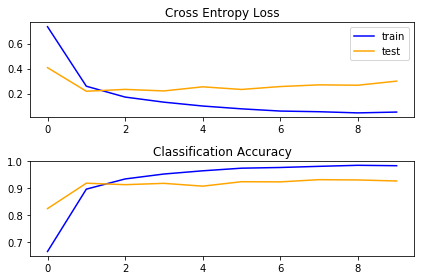

In [215]:
length = max_length
from numpy import array
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.models import Model

# 1. Word Embeddings + CNN = Text Classication
# 2. Use a Single Layer CNN Architecture
# 3. Dial in CNN Hyperparameters
# 4. Consider Character-Level CNNs
# 5. Consider Deeper CNNs for Classication

# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    noise1 = GaussianNoise(0.1)(inputs1)
    embedding1 = Embedding(vocab_size, 300)(noise1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu' ,  )(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # channel 2
    inputs2 = Input(shape=(length,))
#     noise2 = GaussianNoise(0.1)(inputs2)
    embedding2 = Embedding(vocab_size, 300)(noise1)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu' ,)(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # channel 3
    inputs3 = Input(shape=(length,))
#     noise3 = GaussianNoise(0.1)(inputs3)
    embedding3 = Embedding(vocab_size, 300)(noise1)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu',  )(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])
    
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(3, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    model.summary()
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model



# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

Xtrain  = encode_docs(tokenizer, max_length, xtrain_docs)
Xtest  = encode_docs(tokenizer, max_length, xtest_docs)
trainLabels = to_categorical(y_train_docs)

trainX = encode_text(tokenizer, xtrain_docs, max_length)
# define model
model = define_model(length, vocab_size)
# print(model.summary())

testX  = encode_docs(tokenizer, max_length, xtest_docs)
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  

# fit model
history = model.fit([trainX,trainX,trainX], 
                    array(trainLabels),
                    epochs=10,
                    verbose=1,
                    validation_data=([testX,testX,testX],
                                     to_categorical(y_test_docs)) , 
                    callbacks=[checkpoint])

histories = []
histories.append(history)

_,train_acc = model.evaluate([Xtrain,Xtrain,Xtrain], to_categorical(y_train_docs) ,verbose=0)
_, test_acc = model.evaluate([Xtest,Xtest,Xtest], to_categorical(y_test_docs), verbose=0)

print("Training Accuracy :  %.03f , Testing Accuracy : %.03f" %(train_acc ,test_acc) )

summarize_diagnostics(histories)

Training Accuracy :  0.990 , Testing Accuracy : 0.927


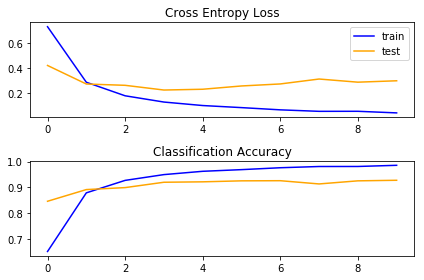

In [199]:
# length = max_length
# from numpy import array
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers import Embedding
# from keras.layers.convolutional import Conv1D
# from keras.layers.merge import concatenate
# from keras.models import Model

# # 1. Word Embeddings + CNN = Text Classication
# # 2. Use a Single Layer CNN Architecture
# # 3. Dial in CNN Hyperparameters
# # 4. Consider Character-Level CNNs
# # 5. Consider Deeper CNNs for Classication

# # define the model
# def define_model(length, vocab_size):
#     # channel 1
#     inputs1 = Input(shape=(length,))
#     embedding1 = Embedding(vocab_size, 300)(inputs1)
#     conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
#     drop1 = Dropout(0.5)(conv1)
#     pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
    
#     # channel 2
#     inputs2 = Input(shape=(length,))
#     embedding2 = Embedding(vocab_size, 300)(inputs2)
#     conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
#     drop2 = Dropout(0.5)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
    
#     # channel 3
#     inputs3 = Input(shape=(length,))
# #     noise = GaussianNoise(0.1)
#     embedding3 = Embedding(vocab_size, 300)(inputs3)
#     conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
#     drop3 = Dropout(0.5)(conv3)
#     pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
    
#     # merge
#     merged = concatenate([flat1, flat2, flat3])
    
#     # interpretation
#     dense1 = Dense(10, activation='relu')(merged)
#     outputs = Dense(3, activation='sigmoid')(dense1)
#     model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
#     # compile
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize
#     model.summary()
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
#     return model



# # encode a list of lines
# def encode_text(tokenizer, lines, length):
#     # integer encode
#     encoded = tokenizer.texts_to_sequences(lines)
#     # pad encoded sequences
#     padded = pad_sequences(encoded, maxlen=length, padding='post')
#     return padded

# vocab_size = len(tokenizer.word_index) + 1
# print(vocab_size)

# Xtrain  = encode_docs(tokenizer, max_length, xtrain_docs)
# Xtest  = encode_docs(tokenizer, max_length, xtest_docs)
# trainLabels = to_categorical(y_train_docs)

# trainX = encode_text(tokenizer, xtrain_docs, max_length)
# # define model
# model = define_model(length, vocab_size)
# # print(model.summary())

# testX  = encode_docs(tokenizer, max_length, xtest_docs)
# checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
#                              verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  

# # fit model
# history = model.fit([trainX,trainX,trainX], 
#                     array(trainLabels),
#                     epochs=25,
#                     verbose=1,
#                     validation_data=([testX,testX,testX],
#                                      to_categorical(y_test_docs)) , 
#                     callbacks=[checkpoint])



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 105)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 105)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 105)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 105, 300)     735300      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_

Train on 7304 samples, validate on 1826 samples
Epoch 1/25
7304/7304 [==============================] - 17s 2ms/step - loss: 0.5625 - acc: 0.7415 - val_loss: 0.1930 - val_acc: 0.9315

Epoch 00001: val_acc improved from -inf to 0.93154, saving model to model-001-0.741512-0.931544.h5
Epoch 2/25
7304/7304 [==============================] - 12s 2ms/step - loss: 0.1303 - acc: 0.9528 - val_loss: 0.1659 - val_acc: 0.9288

Epoch 00002: val_acc did not improve from 0.93154
Epoch 3/25
7304/7304 [==============================] - 12s 2ms/step - loss: 0.0563 - acc: 0.9803 - val_loss: 0.1760 - val_acc: 0.9299

Epoch 00003: val_acc did not improve from 0.93154
Epoch 4/25
7304/7304 [==============================] - 12s 2ms/step - loss: 0.0299 - acc: 0.9914 - val_loss: 0.1927 - val_acc: 0.9359

Epoch 00004: val_acc improved from 0.93154 to 0.93593, saving model to model-004-0.991375-0.935926.h5
Epoch 5/25
7304/7304 [==============================] - 12s 2ms/step - loss: 0.0158 - acc: 0.9955 - val_los

KeyboardInterrupt: 

Training Accuracy :  0.997 , Testing Accuracy : 0.939


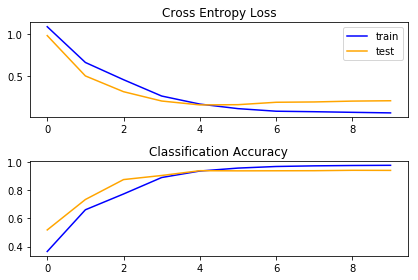

In [207]:
histories = []
histories.append(history)

model = load_model("model-010-0.994934-0.939211.h5")
_,train_acc = model.evaluate([Xtrain,Xtrain,Xtrain], to_categorical(y_train_docs) ,verbose=0)
_, test_acc = model.evaluate([Xtest,Xtest,Xtest], to_categorical(y_test_docs), verbose=0)

print("Training Accuracy :  %.03f , Testing Accuracy : %.03f" %(train_acc ,test_acc) )

summarize_diagnostics(histories)

In [190]:
# loss, accuracy = model.evaluate(trainX, array(trainLabels), verbose=2)
# print('Training Accuracy: %f' % (accuracy*100))

# # evaluate the model
# loss, accuracy = model.evaluate(testX, to_categorical(y_test_docs), verbose=2)
# print('Testing Accuracy: %f' % (accuracy*100))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[ 25,  10,  81, ...,   0,   0,   0],
       [298,  84,  68, ...,   0,   0,   0],
       [ 10,  71,  62, ...,   0,   0,   0],
       ...,
       [ 10, 130, 230, ...,   0,   0,   0],
       [ 25...

In [ ]:
!ls -ltr *.h5

In [ ]:
histories = []
histories.append(history)
summarize_diagnostics(histories)

In [ ]:
### To Reduce OVerfitting in Above graph

In [ ]:
from keras.layers import Bidirectional, LSTM, TimeDistributed

In [ ]:
def blstm_model(length, vocab_size):
    # main model
    input = Input(shape=(length,))
    model = Embedding(vocab_size,300,input_length=length)(input)
    model =  Bidirectional (LSTM (300,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(300,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(200,activation='relu')(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model = blstm_model(length, vocab_size)
print(model.summary())

model.fit(trainX,trainLabels,validation_split=0.25, epochs = 20, verbose = 1)

loss, accuracy = model.evaluate(trainX, array(trainLabels), verbose=2)
print('Training Accuracy: %f' % (accuracy*100))

# evaluate the model
loss, accuracy = model.evaluate(testX, to_categorical(y_test_docs), verbose=2)
print('Testing Accuracy: %f' % (accuracy*100))

In [ ]:
summarize_diagnostics(history)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')


# fit model
history = model.fit([trainX,trainX,trainX],
                    array(trainLabels), 
                    epochs=20,
                    batch_size=32 ,
                    verbose = 0,
                    validation_data=([testX,testX,testX],
                                     to_categorical(y_test_docs)))

In [ ]:
batch_size = 32

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# validation_data=([testX,testX,testX],to_categorical(y_test_docs)))

# fit model
history = model.fit([trainX,trainX,trainX],
                    array(trainLabels), 
                    epochs=20,
                    batch_size=32 ,
                    verbose = 1,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],validation_split=0.25)

In [ ]:
# # fit model
# history = model.fit([trainX,trainX,trainX],
#                     array(trainLabels), 
#                     epochs=20,
#                     batch_size=32 ,
#                     verbose = 0,
#                     callbacks=[earlyStopping, mcp_save, reduce_lr_loss],validation_split=0.25)
# #                     validation_data=([testX,testX,testX],to_categorical(y_test_docs)))

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
# # fit model
# history = model.fit([trainX,trainX,trainX], array(trainLabels), epochs=20,
#                     batch_size=32 ,
#                     validation_data=([testX,testX,testX],to_categorical(y_test_docs)))

In [ ]:
import sys
from matplotlib import pyplot
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
# plot diagnostic learning curves    
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.tight_layout()
    pyplot.legend()
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    
    pyplot.tight_layout()
    pyplot.legend()
    pyplot.show()
    pyplot.close()
summarize_diagnostics(history)

In [ ]:
%matplotlib inline

In [ ]:
summarize_diagnostics(history)

In [ ]:
summarize_diagnostics(history)

In [ ]:
model.save('ng_model_model_multiinput_NEW.h5')

In [ ]:
model.predict([enc_docs,enc_docs,enc_docs])

In [ ]:
# load the model
from keras.models import load_model
# save the model
model.save('model_multi_nightingale.h5')
model = load_model('model_multi_nightingale.h5')

In [ ]:
max_length

In [ ]:
# evaluate model on training dataset
_, acc = model.evaluate([trainX,trainX,trainX],to_categorical(y_train_docs), verbose=2)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset dataset
_, acc = model.evaluate([testX,testX,testX],to_categorical(y_test_docs), verbose=2)
print('Test Accuracy: %.2f' % (acc*100))

#### Build vocab with weights for embedding space generation

In [ ]:
import pandas as pd
import numpy as np
from numpy import   asarray,zeros
# load the whole embedding into memory
embeddings_index = dict()
# f = open('/home/surya/cs224n-Squad-Project/data/glove.6B.100d.txt')
f = open('/root/data/glove/glove.6B.300d.txt')


for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
vocab_size

In [ ]:
docs[0]

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(clean_doc_voc)
vocab_size = len(t.word_index) + 1
vocab_size

In [ ]:
a = "0.41711,-0.10176,0.058147,-0.18332,-0.44458,-0.17852,-0.34392,-0.077147,0.58521,-0.52752,1.4831,0.9531,-0.027201,-0.31748,-0.23046,-0.24083,0.22548,-0.12685,-0.17578,-0.34924,0.5168,0.86818,-0.018579,1.2228,-0.52477,-0.26369,0.25925,-0.059529,0.27063,0.13036,-0.67677,0.48313,-0.16343,-0.069899,0.92846,-0.44196,-0.078755,0.5246,-0.59577,-0.1659,0.35194,0.30031,-0.50711,0.29111,-0.26332,-1.0523,-0.31061,-0.077155,-0.16019,0.26994,-1.1042,0.16292,0.79396,-0.77135,-0.95157,-0.55992,0.69163,0.021495,0.44292,-0.69881, 0.73889,-0.1064,-0.44058,0.17116,0.39109,0.043652, 1.2835,0.29026,0.51037,-0.19631,0.036696  -0.74017,-0.0035271 -0.54918,-0.25002,0.15853,0.71764,-0.28083, 0.42292,-0.89855,0.99665,-0.65188,-0.11919,-0.28617,-0.85273,0.55656,-0.23601,-0.43822,0.36317,0.45724, 0.38596,0.59233,1.4355,1.4563,1.1801,0.32987, 0.84998,-0.29444,-0.039114,0.39534".split(",")

a = np.array(a)
len(a)

In [ ]:
# embedding_matrix = zeros((vocab_size, 100))
embedding_matrix = zeros((vocab_size, 300))

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
#     print((word,i),embedding_vector)
if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
# e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

###  ADD USER DEFINED EMBEDDING FROM GLOVE 

In [ ]:
embedding_matrix.shape

In [ ]:
%timeit 
# np.isnan(data)[np.isnan(data) == False].size
np.isnan(embedding_matrix)[np.isnan(embedding_matrix) == False].size

In [ ]:
# t.word_index.items()

In [ ]:
# embedding_matrix
np.sum(~embedding_matrix.any(1))

In [ ]:
embedding_matrix

In [ ]:
# define the model
def define_model(vocab_size, max_length , custom_embed = True):
    model = Sequential()
#     model.add(Embedding(vocab_size, 100, input_length=max_length))
#     model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length , trainable=False))
    model.add(Embedding(vocab_size, 300, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    print("Hello!!!!!!!!!")
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize defined model
    model.summary()
#     model.layers[0].set_weights([embedding_matrix])
#     model.layers[0].trainable = False
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
#    #load different embedding file from Kaggle depending on which embedding 
#         #matrix we are going to experiment with
#         if typeToLoad=="glove":
#             EMBEDDING_FILE='../input/glove-twitter/glove.twitter.27B.25d.txt'
#             embed_size = 25
#         elif(typeToLoad=="word2vec"):
#             word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
#             embed_size = 300
#         elif(typeToLoad=="fasttext"):
#             EMBEDDING_FILE='../input/fasttext/wiki.simple.vec'
#             embed_size = 300

#         if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
#             embeddings_index = dict()
#             #Transfer the embedding weights into a dictionary by iterating through every line of the file.
#             f = open(EMBEDDING_FILE)
#             for line in f:
#                 #split up line into an indexed array
#                 values = line.split()
#                 #first index is word
#                 word = values[0]
#                 #store the rest of the values in the array as a new array
#                 coefs = np.asarray(values[1:], dtype='float32')
#                 embeddings_index[word] = coefs #50 dimensions
#             f.close()
#             print('Loaded %s word vectors.' % len(embeddings_index))
#         else:
#             embeddings_index = dict()
#             for word in word2vecDict.wv.vocab:
#                 embeddings_index[word] = word2vecDict.word_vec(word)
#             print('Loaded %s word vectors.' % len(embeddings_index))
            
#         gc.collect()
#         #We get the mean and standard deviation of the embedding weights so that we could maintain the 
#         #same statistics for the rest of our own random generated weights. 
#         all_embs = np.stack(list(embeddings_index.values()))
#         emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
#         nb_words = len(tokenizer.word_index)
#         #We are going to set the embedding size to the pretrained dimension as we are replicating it.
#         #the size will be Number of Words in Vocab X Embedding Size
#         embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
#         gc.collect()

#         #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
#         #our own dictionary and loaded pretrained embedding. 
#         embeddedCount = 0
#         for word, i in tokenizer.word_index.items():
#             i-=1
#             #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
#             embedding_vector = embeddings_index.get(word)
#             #and store inside the embedding matrix that we will train later on.
#             if embedding_vector is not None: 
#                 embedding_matrix[i] = embedding_vector
#                 embeddedCount+=1
#         print('total embedded:',embeddedCount,'common words')
        
#         del(embeddings_index)
#         gc.collect()
        
#         #finally, return the embedding matrix
#         return embedding_matrix

In [ ]:
max_length

In [ ]:
model = define_model(vocab_size,max_length,True)
model.fit(Xtrain, to_categorical(y_train_docs), epochs=80, verbose=2, validation_split=0.1)

In [ ]:
model.metrics_names

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# # This tutorial is divided into the following parts:
# 1. Word Embeddings + CNN = Text Classication
# 2. Use a Single Layer CNN Architecture
# 3. Dial in CNN Hyperparameters
# 4. Consider Character-Level CNNs
# 5. Consider Deeper CNNs for Classication

# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 300)(inputs1)
#     embedding1 = Embedding(vocab_size,  300, weights=[embedding_matrix], trainable=False)(inputs1)
#         model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length , trainable=False))

    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 300)(inputs2)
#     embedding2 = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 300)(inputs3)
#     embedding3 = Embedding(vocab_size, 100)(embedding3)
#     embedding3 = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs3)

    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])
    
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(3, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    model.summary()
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
trainX = encode_text(tokenizer, xtrain_docs, max_length)

In [ ]:
trainX = encode_text(tokenizer, xtrain_docs, max_length)
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], array(trainLabels), epochs=100, batch_size=16 , )

In [ ]:
keras_model = model
import tensorflow as tf

In [ ]:
! ls -ltr /home/surya/model_multi_nightingale.h5

In [ ]:
model.save("model_multi_nightingale_NEW.h5")

In [ ]:
test_data = "Hello John,How can I help to you I take toomuch coffe, with out coffee I feel headache Is it a throbbing headache? No How does bending forward affect your headache? I feel severing with out coffe How would you describe the intensity of your headache? sever headache with out coffee Do you become frustrated or upset easily?  I will sclod people near me Have you recently used any drugs in any form? No Do you experience day time sleep? restless Do you tend to drink alcohol heavily? I drink too much coffee Are you feeling agitated and physically restless? Feeling fatigued and lack of energy nearly every day."
test_data = "Hello John,How can I help to you severe headache and seizures Is it a throbbing headache? not at all How does bending forward affect your headache? severe pain at bothsides of my forehead How would you describe the intensity of your headache? it is worst, am not able to tolerate Do you become frustrated or upset easily? not all the times but some times Have you recently used any drugs in any form? being around smoke , certain smells bright light, such as sunlight, or flashing lights Do you experience day time sleep? In day time I feel sleepy, I will struggle to remain awake Do you tend to drink alcohol heavily? Yes, I tend to drink alcohol heavily? Are you feeling agitated and physically restless? especially lack of sleep I am  agitated"



enc_docs = encode_docs(tokenizer, max_length, [test_data])
enc_docs

In [ ]:
out = model.predict([enc_docs,enc_docs,enc_docs])
arr = out[0]
arr.argmax()

In [ ]:
!

In [ ]:
max_length

In [ ]:
# saved_model_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")


In [ ]:

!pwd

In [ ]:
with tf.keras.backend.get_session() as sess:
    tf.saved_model.simple_save(
        sess,
        "export_path",
        inputs={'input': keras_model.input},
        outputs={'output': keras_model.output})

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
keras.experimental.export_saved_model(model, '/home/surya/saved_model')


In [ ]:
# Export the model to a SavedModel
keras.experimental.export_saved_model(model, 'path_to_saved_model')

# Recreate the exact same model
new_model = keras.experimental.load_from_saved_model('path_to_saved_model')

# Check that the state is preserved
new_predictions = new_model.predict(x_test)
np.testing.assert_allclose(predictions, new_predictions, atol=1e-6)

# Note that the optimizer state is preserved as well:
# you can resume training where you left off.

In [ ]:


with mlflow.start_run() as run:
    mlflow.keras.log_model(model, "models")

In [ ]:
# model
mlflow.keras.save_model(model, "models_keras")

In [ ]:
>>> import mlflow
>>> # Build, compile, and train your model
>>> keras_model = ...
>>> keras_model_path = ...
>>> keras_model.compile(optimizer="rmsprop", loss="mse", metrics=["accuracy"])
>>> results = keras_model.fit(
...     x_train, y_train, epochs=20, batch_size = 128, validation_data=(x_val, y_val))
... # Save the model as an MLflow Model
>>> mlflow.keras.save_model(keras_model, keras_model_path)

In [ ]:
# 20.5.2 Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
## Prepare iterator
it_data = datagen.flow(trainX, trainY, batch_size=64)
steps = int (trainX.shape[0]/64)

history = model.fit_generator(it_data,steps_per_epoch=steps,epochs=100, validation_data=(testX, testY))
